# Legacy vs EIP 1559 users in post EIP 1559 world

###### November 2020, [@mkomorowski](https://twitter.com/mkomorowski) / [michalkomorowski.com](https://www.michalkomorowski.com)
###### [NETHERMIND](https://nethermind.io/)

---

The goal of this notebook is to simulate legacy and EIP-1559 users in post EIP-1559 world and see how they will be treated by the network.

The code below is based on [`abm1559`](https://github.com/barnabemonnot/abm1559) library which however was slightly modified in order to meet requirements of this simulation.

__Comments and suggestions are welcome.__

Let's start with loading required classes.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath('abm1559'))
# You may remove the two lines above if you have installed abm1559 from pypi

from typing import Sequence

from abm1559.utils import constants

from abm1559.config import rng

from abm1559.txpool import TxPool

from abm1559.txs import Tx1559

from abm1559.users import (User, User1559, AffineUser)

from abm1559.userpool import UserPool

from abm1559.chain import (Chain, Block1559)

from abm1559.simulator import (spawn_poisson_heterogeneous_demand, update_basefee)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

These are some constants that control the simulation and are used further in the code.

In [2]:
SLOW = 0.2
FAST = 0.8

SLOW_EXPECTED_TIME = 10
AVERAGE_EXPECTED_TIME = 5 
FAST_EXPECTED_TIME = 0

SLOW_PRICE = "slow_price"
AVERAGE_PRICE = "avg_price"
FAST_PRICE = "fast_price"

SLOW_TIP = "slow_tip"
AVERAGE_TIP = "avg_tip"
FAST_TIP = "fast_tip"

MAX_TX_IN_BLOCK = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])
MAX_TRANSACTIONS_IN_POOL= 10000

## Legacy users

In order to see how legacy users will be treated in post EIP-1559 world we need to model them somehow. The main difference between legacy users and EIP-1559 users lays in the fact that for legacy users _gas premium_ = _max fee_ = old _gas price_.

It is also worth pointing that legacy users will generate EIP-1559 transactions, just like EIP-1559 users, but with different parameters.  Taking this into account `LegacyUser` class was derived from `AffineUser` from __abm1559__ library and its behaviour was modified in the following way.

1. In the constructor the urgency is determined. Urgency states the expectation of a user regarding how many blocks his transaction will wait for inclusion (see `self.expected_time_value`). To do that a helper function `get_expected_time` is used.

2. `decide_parameters` function, which returns parameters for a transaction, was overridden to return the old gas price based on the urgency. The higher urgency the higher price. The old gas price is determined based on the transaction pool analysis. See `calc_prices_and_tip_based_on_urgency` later on. 

In [3]:
def get_expected_time(rng):
    res = rng.uniform(low = 0, high = 1)
    if res <= SLOW:
        return SLOW_EXPECTED_TIME
    elif res >= FAST:
        return FAST_EXPECTED_TIME
    else:
        return AVERAGE_EXPECTED_TIME

In [4]:
class LegacyUser(AffineUser):
    def __init__(self, wakeup_block, expected_time_value=None, cost_per_unit=None, **kwargs):
        super().__init__(wakeup_block, **kwargs)
        
        self.expected_time_value = get_expected_time(self.rng) if expected_time_value is None else expected_time_value
        
    def expected_time(self, env):
        return self.expected_time_value
    
    def decide_parameters(self, env):
        price_to_use = AVERAGE_PRICE
        if self.expected_time_value == SLOW_EXPECTED_TIME:
            key = SLOW_PRICE
        elif self.expected_time_value == FAST_EXPECTED_TIME:
            key = FAST_PRICE
            
        old_gas_price = env[price_to_use] if price_to_use in env else 0
        
        if old_gas_price == 0: # 0 means that there were no valid transactions in the pool
            old_gas_price = self.value
            
        gas_premium = old_gas_price 
        max_fee = old_gas_price

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block,
        }
    
    def create_transaction(self, env):
        tx_params = self.decide_parameters(env)
        
        tx = Tx1559(sender = self.pub_key, params = tx_params)

        expected_block = self.wakeup_block + self.expected_time(env)
        expected_gas_price = tx_params["max_fee"] # max_fee = old_gas_price
        
        expected_payoff = self.payoff({
            "gas_price": expected_gas_price,
            "current_block": expected_block,
        })
        
        if expected_payoff <= 0:
            return None

        return tx
    
    def export(self):
        return {
            **super().export(),
            "user_type": "legacy_user",
        }

    def __str__(self):
        return f"Legacy affine user with value {self.value} and cost {self.cost_per_unit}"

## Clever User 1559

The library **abm1559** contains `User1559` but we need a class that will have a similar behaviour as `LegacyUser` defined above. Thanks to that the comparison will be more reliable. Taking this into account `CleverUser1559` class was defined. Users of this type:

1. Have different expectations regarding when their transactions will be included in a block.
2. Analyze the transaction pool in order do determine the optimal gas premium.

In [5]:
class CleverUser1559(User1559):
    def __init__(self, wakeup_block, expected_time_value=None, cost_per_unit=None, **kwargs):
        super().__init__(wakeup_block, **kwargs)
        
        self.expected_time_value = get_expected_time(self.rng) if expected_time_value is None else expected_time_value

    def expected_time(self, env):
        return self.expected_time_value
    
    def decide_parameters(self, env):
        max_fee = self.value
        
        tip_to_use = AVERAGE_TIP
        if self.expected_time_value == SLOW_EXPECTED_TIME:
            key = SLOW_TIP
        elif self.expected_time_value == FAST_EXPECTED_TIME:
            key = FAST_TIP
            
        tip = env[tip_to_use] if tip_to_use in env else 1 * (10 ** 9)
           
        return {
            "max_fee": max_fee, # in wei
            "gas_premium": tip, # in wei
            "start_block": self.wakeup_block,
        }
    
    def export(self):
        return {
            **super().export(),
            "user_type": "clever_user_1559",
        }

    def __str__(self):
        return f"Clever 1559 affine user with value {self.value} and cost {self.cost_per_unit}"

## Simulation

Now we need a few helper functions to run a simulation. `calc_prices_and_tip_based_on_urgency` analyzes a transaction pool and calculates the minimal gas price / tip for a transaction depending on its urgency: slow, average, fast. 

For example, if a transaction can wait for 2 blocks (i.e. it should be included in 3rd block), then the algorithm finds a transaction at 3 * MAX_TX_IN_BLOCK'th position and checks its gas price and tip. Then 1 gwei is added to the found value. The result is saved in environment variables and then will be used accordingly by instances of `LegacyUser` and `CleverUser1559`.

In order to find transactions that will be included in blocks, they are sorted based on a tip (just like in `TxPool.select_transactions` method in __abm1559__ library).

In [6]:
def calc_prices_and_tip_based_on_urgency(params, txpool):
        
    def get_price(params, txs, offset):
        if len(txs) == 0:
            return 0
        
        # If there is not enough transactions, let's take the last available.
        if len(txs) <= offset:
            return txs[-1].gas_price(params) + 1 * 10 ** 9
        else:
            return txs[offset].gas_price(params) + 1 * 10 ** 9
    
    def get_tip(params, txs, offset):
        if len(txs) == 0:
            return 0
        
        # If there is not enough transactions, let's take the last available.
        if len(txs) <= offset:
            return txs[-1].tip(params) + 1 * 10 ** 9
        else:
            return txs[offset].tip(params) + 1 * 10 ** 9
        
    valid_txs = [tx for tx in txpool.txs.values() if tx.is_valid(params)]
    sorted_valid_demand = sorted(
        valid_txs,
        key = lambda tx: -tx.tip(params)
    )

    params[SLOW_PRICE] = get_price(params, sorted_valid_demand, (SLOW_EXPECTED_TIME + 1) * MAX_TX_IN_BLOCK)
    params[AVERAGE_PRICE] = get_price(params, sorted_valid_demand, (AVERAGE_EXPECTED_TIME + 1) * MAX_TX_IN_BLOCK)
    params[FAST_PRICE] = get_price(params, sorted_valid_demand, (FAST_EXPECTED_TIME + 1) * MAX_TX_IN_BLOCK)
    
    params[SLOW_TIP] = get_tip(params, sorted_valid_demand, (SLOW_EXPECTED_TIME + 1) * MAX_TX_IN_BLOCK)
    params[AVERAGE_TIP] = get_tip(params, sorted_valid_demand, (AVERAGE_EXPECTED_TIME + 1) * MAX_TX_IN_BLOCK)
    params[FAST_TIP] = get_tip(params, sorted_valid_demand, (FAST_EXPECTED_TIME + 1) * MAX_TX_IN_BLOCK)

This method does not allow txs pool to grow too much. If the number of transactions in the transaction pool exceeds the defined maximum (see `MAX_TRANSACTION_IN_POOL`), transactions are sorted (in the same way as in `TxPool.select_transactions` method) and the worst are removed.

In [7]:
def evict(txpool, params):
    if txpool.pool_length > MAX_TRANSACTIONS_IN_POOL:
        txs = txpool.txs
        sorted_txs= sorted(txs.values(), key = lambda tx: -tx.tip(params))
        txpool.empty_pool()
        txpool.add_txs(sorted_txs[0:MAX_TRANSACTIONS_IN_POOL])
        return sorted_txs[MAX_TRANSACTIONS_IN_POOL:]
    
    return []

The last important helper function is `custom_spawn_poisson_heterogeneous_demand`. The idea is to compare transactions created by users of diffrent types (behaviour) but with the same parameters. These parameters are:

1. The value a user expectes to have from having their transaction included in a block.
2. The urgency i.e. the expectation of a user regarding how many blocks his transaction will wait for inclusion in a block.

To do that `custom_spawn_poisson_heterogeneous_demand` creates a pair of `LegacyUser` and `CleverUser1559` with the same values of parameters mentioned above. 

Additionally, it was decided to add one more user to this pair, so called naive EIP-1559 user (instance of `User1559` from __abm1559__ library). This user in comparison to `LegacyUser` and `CleverUser1559` is "lazy", does not analyze the transaction pool and always sets the gas premium to 1 gwei. 

In [8]:
def custom_spawn_poisson_heterogeneous_demand(timestep: int, demand_lambda: float, rng=rng) -> Sequence[User]:
    new_users = []
    demand_size = rng.poisson(demand_lambda)
    for i in range(demand_size):
        value = int(rng.uniform(low = 0, high = 20) * (10 ** 9)) # See `User.__init__`
        expected_time_value = get_expected_time(rng)
        
        legacy = LegacyUser(timestep, rng=rng)
        legacy.value = value
        legacy.expected_time_value = expected_time_value
        
        eip_1559 = CleverUser1559(timestep, rng=rng)
        eip_1559.value = value
        legacy.expected_time_value = expected_time_value
        
        eip_1559_naive = User1559(timestep, rng=rng)
        eip_1559_naive.value = value
        
        new_users.append(legacy)
        new_users.append(eip_1559)        
        new_users.append(eip_1559_naive)
    return new_users

`simulate` is a core of the simulation and it is based on the code from [__Strategic users in EIP 1559__](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb). notebook. The main changes are:

1. It has an additional parameter `use_custom_demand`. If it is set to `True` then users are generated with `custom_spawn_poisson_heterogeneous_demand` method instead of `spawn_poisson_heterogeneous_demand`.
2. `calc_prices_and_tip_based_on_urgency` is called to estimate prices used by `LegacyUser` and tips used by `CleverUser1559`.
3. `evict` is called to limit the number of transactions in the pool.
4. Additional metrics are calculated. This simulation uses 4 counters for transactions submitted by different types of users accumulate: number of transactions included in blocks so far, number of the evicted transaction so far, waiting time for inclusion in a block so far, paid gas price so far. These counters allow us to calculate average values which are then plotted.

In [9]:
def simulate(demand_scenario, shares_scenario, use_custom_demand):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)
    params = {}
    
    txs_count_so_far = { LegacyUser: 0, CleverUser1559: 0, User1559: 0 }
    evicted_txs_count_so_far = { LegacyUser: 0, CleverUser1559: 0, User1559: 0 }
    txs_waiting_time_so_far = { LegacyUser: 0, CleverUser1559: 0, User1559: 0 }
    txs_gas_price_so_far = { LegacyUser: 0, CleverUser1559: 0, User1559: 0 }
    stats = (txs_count_so_far, evicted_txs_count_so_far, txs_waiting_time_so_far, txs_gas_price_so_far)
    
    for t in tqdm(range(len(demand_scenario))):
        
        # `params` are the "environment" of the simulation
        params["basefee"] = basefee
        params["current_block"] = t
        params["min_premium"] = min_premium
            
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        
        if use_custom_demand:
            users = custom_spawn_poisson_heterogeneous_demand(t, demand_scenario[t])
        else:
            users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # Let's calculate prices that will be used by legacy transactions.
        # It is important to call this method here. If we call it, when remove_txs has been already called, then 
        # transactions included in blocks will never be taken into account while estimating prices.
        calc_prices_and_tip_based_on_urgency(params, txpool)
            
        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])
        
        #Let's clear txpool if needed
        evicted_txs = evict(txpool, params)

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # Record the min premium in the block
        min_premium = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)
        
        # A couple of metrics we will use to monitor the simulation
        
        # Legacy
        (pool_legacy_users, blk_legacy_txs_avg_gas_price) = collect_statistics(
            stats, LegacyUser, txpool, user_pool, selected_txs, evicted_txs, basefee, t)
        (pool_1559_users, blk_clever_1559_txs_avg_gas_price) = collect_statistics(
            stats, CleverUser1559, txpool, user_pool, selected_txs, evicted_txs, basefee, t)
        (pool_naive_1559_users, blk_naive_1559_txs_avg_gas_price) = collect_statistics(
            stats, User1559, txpool, user_pool, selected_txs, evicted_txs, basefee, t)
        
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "legacy": len([user for user in users if isinstance(user, LegacyUser)]),
            "nonlegacy": len([user for user in users if isinstance(user, User1559)]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_legacy_txs_avg_gas_price": blk_legacy_txs_avg_gas_price,
            "blk_clever_1559_txs_avg_gas_price": blk_clever_1559_txs_avg_gas_price,
            "blk_naive_1559_txs_avg_gas_price": blk_naive_1559_txs_avg_gas_price,
            "blk_avg_tip": block.average_tip(),
            
            "legacy_txs_avg_gas_price_so_far": 0 if txs_count_so_far[LegacyUser] == 0 else txs_gas_price_so_far[LegacyUser] / txs_count_so_far[LegacyUser] / (10 ** 9),
            "legacy_txs_avg_waiting_time_so_far": 0 if txs_count_so_far[LegacyUser] == 0 else txs_waiting_time_so_far[LegacyUser] / txs_count_so_far[LegacyUser],
            "ratio_of_evicted_legacy_txs":  0 if txs_count_so_far[LegacyUser] == 0 else evicted_txs_count_so_far[LegacyUser] / txs_count_so_far[LegacyUser],
            
            "clever_eip_1559_txs_avg_gas_price_so_far": 0 if txs_count_so_far[CleverUser1559] == 0 else txs_gas_price_so_far[CleverUser1559] / txs_count_so_far[CleverUser1559] / (10 ** 9),
            "clever_eip_1559_txs_avg_waiting_time_so_far": 0 if txs_count_so_far[CleverUser1559] == 0 else txs_waiting_time_so_far[CleverUser1559] / txs_count_so_far[CleverUser1559],
            "ratio_of_evicted_clever_eip_1559_txs":  0 if txs_count_so_far[CleverUser1559] == 0 else evicted_txs_count_so_far[CleverUser1559] / txs_count_so_far[CleverUser1559],
            
            "naive_eip_1559_txs_avg_gas_price_so_far": 0 if txs_count_so_far[User1559] == 0 else txs_gas_price_so_far[User1559] / txs_count_so_far[User1559] / (10 ** 9),  
            "naive_eip_1559_txs_avg_waiting_time_so_far": 0 if txs_count_so_far[User1559] == 0 else txs_waiting_time_so_far[User1559] / txs_count_so_far[User1559],
            "ratio_of_evicted_naive_eip_1559_txs":  0 if txs_count_so_far[User1559] == 0 else evicted_txs_count_so_far[User1559] / txs_count_so_far[User1559],
            
            "pool_length": txpool.pool_length,
            "pool_legacy_users": pool_legacy_users,
            "pool_clever_1559_users": pool_1559_users,            
            "pool_naive_1559_users": pool_naive_1559_users
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain, txpool)

We need a few more helper funcion to collect statistics, draw plots etc. but they are not so important.

In [10]:
def collect_statistics(stats, user_type, tx_pool, user_pool, selected_txs, evicted_txs, basefee, t):
        (txs_count_so_far, evicted_txs_count_so_far, txs_waiting_time_so_far, txs_gas_price_so_far) = stats
        
        pool = [tx for tx in tx_pool.txs.values() if type(user_pool.users[tx.sender]) == user_type]
        
        txs = [tx for tx in selected_txs if type(user_pool.users[tx.sender]) == user_type]
        evicted_txs = [tx for tx in evicted_txs if type(user_pool.users[tx.sender]) == user_type]
        
        txs_count_so_far[user_type] += len(txs)
        evicted_txs_count_so_far[user_type] += len(evicted_txs)
        
        txs_gas_price_in_block = 0 if len(txs) == 0 else sum(
            [tx.gas_price({"basefee": basefee, "current_block": t }) for tx in txs])
        
        txs_gas_price_so_far[user_type] += txs_gas_price_in_block 
        txs_waiting_time_so_far[user_type] += sum([t - tx.start_block for tx in txs])
        
        blk_avg_gas_price = 0 if len(txs) == 0 else txs_gas_price_in_block / len(txs) / (10 ** 9)
        
        return (len(pool), blk_avg_gas_price)     

Some helper functions to draw nice plots. From my perspective the first 6 plots are the most interesting. If you need more set `basicOnes` to `False`.

In [11]:
def drawPlots(df, user_pool, chain, column = -1, axes = None, basicOnes = True):
   
    def get_ax(axes, row, column):
        if column < 0:
            return None
        
        if not hasattr(axes[row], "__getitem__"):
            return axes[row]
        
        return axes[row][column]

    # Obtain the pool of users (all users spawned by the simulation)
    user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })
    # Export the trace of the chain, all transactions included in blocks
    chain_df = chain.export()
    # Join the two to associate transactions with their senders
    user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")
    
    # Obtain per user type statistics
    txs_per_user_type = user_txs_df.groupby(
        ["block_height", "user_type"]
    ).agg(
        { 
            "user_type": len,          
            "value": np.mean
        }
    ).unstack(level=-1).reset_index()

    txs_per_user_type["user_type"] = txs_per_user_type["user_type"].fillna(0)
    txs_per_user_type["value"] = txs_per_user_type["value"].fillna(0)

    new_columns = ["block"]
    for c in  txs_per_user_type.columns:
        if c[0] == "user_type":
            if c[1] == "legacy_user":
                new_columns.append("legacy_count")
            elif c[1] == "clever_user_1559":
                new_columns.append("clever_1559_count")
            elif c[1] == "user_1559":
                new_columns.append("naive_1559_count")
        elif c[0] == "value":
            if c[1] == "legacy_user":
                new_columns.append("avg_legacy_user_value")
            elif c[1] == "clever_user_1559":
                new_columns.append("avg_user_clever_1559_value")
            elif c[1] == "user_1559":
                new_columns.append("avg_user_naive_1559_value")
                
    txs_per_user_type.columns = new_columns
    
    if "legacy_count" not in new_columns:
        txs_per_user_type["legacy_count"] = 0
    if "clever_1559_count" not in new_columns:
        txs_per_user_type["clever_1559_count"] = 0
    if "naive_1559_count" not in new_columns:
        txs_per_user_type["naive_1559_count"] = 0
        
    if "avg_legacy_user_value" not in new_columns:
        txs_per_user_type["avg_legacy_user_value"] = 0
    if "avg_user_clever_1559_value" not in new_columns:
        txs_per_user_type["avg_user_clever_1559_value"] = 0
    if "avg_user_naive_1559_value" not in new_columns:
        txs_per_user_type["avg_user_naive_1559_value"] = 0

    txs_per_user_type["blk_min_premium"] = df["blk_min_premium"]

    txs_per_user_type["total"] = txs_per_user_type.apply(
        lambda row: row.legacy_count + row.clever_1559_count + row.naive_1559_count,
        axis = 1)
    txs_per_user_type["percent_legacy"] = txs_per_user_type.apply(
        lambda row: row.legacy_count / row.total * 100,
        axis = 1)    
    txs_per_user_type["percent_clever_1559"] = txs_per_user_type.apply(
        lambda row: row.clever_1559_count / row.total * 100,
        axis = 1)    
    txs_per_user_type["percent_naive_1559"] = txs_per_user_type.apply(
        lambda row: row.naive_1559_count / row.total * 100, 
        axis = 1)
    
    
    row = 0
    df.plot("block", ["basefee", "blk_min_premium"], 
            ax = get_ax(axes, row, column))
    
    row+=1
    df.plot("block", ["legacy_txs_avg_gas_price_so_far", "clever_eip_1559_txs_avg_gas_price_so_far", "naive_eip_1559_txs_avg_gas_price_so_far"], 
            title ="Average gas price so far", 
            ax = get_ax(axes, row, column))
    
    row+=1
    df.plot("block", ["blk_legacy_txs_avg_gas_price", "blk_clever_1559_txs_avg_gas_price", "blk_naive_1559_txs_avg_gas_price"], #, "blk_avg_gas_price"],            
            title ="Avgerage gas price per block", 
            ax = get_ax(axes, row, column))
    
    
    row+=1
    df.plot("block", ["legacy_txs_avg_waiting_time_so_far", "clever_eip_1559_txs_avg_waiting_time_so_far", "naive_eip_1559_txs_avg_waiting_time_so_far"], 
            title ="Average waiting time of included txs so far", 
            ax = get_ax(axes, row, column))
    
    row+=1
    df.plot("block", ["ratio_of_evicted_legacy_txs", "ratio_of_evicted_clever_eip_1559_txs",  "ratio_of_evicted_naive_eip_1559_txs"], 
            title ="Ratio of evicted to included txs so far", 
            ax = get_ax(axes, row, column))

    row+=1
    df.plot("block", ["pool_legacy_users", "pool_clever_1559_users", "pool_naive_1559_users", "pool_length", "users"], 
            title ="Transaction pool statistics", 
            ax = get_ax(axes, row, column))
    
    row+=1
    txs_per_user_type.plot("block", ["percent_legacy", "percent_clever_1559", "percent_naive_1559"],
                           title = 'Percent of legacy vs. 1559 users in the blocks', 
                           ax = get_ax(axes, row, column))
    
    if basicOnes == True:
        return
    
    row+=1
    df.plot("block", ["decided_txs", "included_txs"],            
            title ="Decided vs included txs", 
            ax = get_ax(axes, row, column))  
    
    row+=1
    txs_per_user_type.plot("block", ["legacy_count", "clever_1559_count", "naive_1559_count", "total"],
                          title = 'The distribution of the number of\nlegacy vs. 1559 users in the blocks', 
                           ax = get_ax(axes, row, column))    
    
    row+=1
    txs_per_user_type.plot("block", ["avg_legacy_user_value", "avg_user_clever_1559_value", "avg_user_naive_1559_value", "blk_min_premium"], 
                           title = 'The distribution of average value of\nlegacy vs. 1559 users in the blocks',                      
                           ax = get_ax(axes, row, column))


In [12]:
def drawAllPlots(res, basicOnes = True):
    no_of_columns = len(res)
    fig, axes = plt.subplots(7 if basicOnes else 10, no_of_columns, figsize=(20,20))
    
    for i in range(len(res)):
        (df, user_pool, chain, _) = res[i]
        drawPlots(df, user_pool, chain, i, axes, basicOnes)

    plt.tight_layout()
    plt.savefig('legacyTransactions.png')

Other helper functions that makes running sumulations easier. `run_in_old_way` method run the simulation in the same way as original __Strategic users in EIP 1559__ notebook while `run_with_custom_demand` sets `use_custom_demand` to `True`.

In [13]:
def run_in_old_way(legacy_share, blocks):
    demand_scenario = [3000 for i in range(int(blocks))]

    shares_scenario = [{
        LegacyUser: legacy_share,
        CleverUser1559: 1 - legacy_share,
    } for i in range(blocks)]

    (df, user_pool, chain, txpool) = simulate(
        demand_scenario, 
        shares_scenario, 
        use_custom_demand = False)
    return (df, user_pool, chain, txpool)

In [14]:
def run_with_custom_demand(blocks, no_of_users_per_type):
    demand_scenario = [no_of_users_per_type for i in range(int(blocks))]

    (df, user_pool, chain, txpool) = simulate(
        demand_scenario, 
        None, 
        use_custom_demand = True)
    return (df, user_pool, chain, txpool)

Let's run some simulations.

In [15]:
iterations = 200
res = []

# Use LegacyUser and CleverUser1559 in various proportions. Here we use spawn_poisson_heterogeneous_demand.
#res.append(run_in_old_way(0.1, iterations))
#res.append(run_in_old_way(0.5, iterations))
#res.append(run_in_old_way(0.8, iterations))

# Use LegacyUser, CleverUser1559, User1559. Here we use custom_spawn_poisson_heterogeneous_demand.
res.append(run_with_custom_demand(iterations, no_of_users_per_type = 1000))
res.append(run_with_custom_demand(iterations, no_of_users_per_type = 2000))

100%|██████████| 200/200 [01:14<00:00,  2.70it/s]


Let's draw 1 figure with all plots. It will also saved on the disk in the same directory as the notebook. If you want to see more diagrams change `True` to `False`.

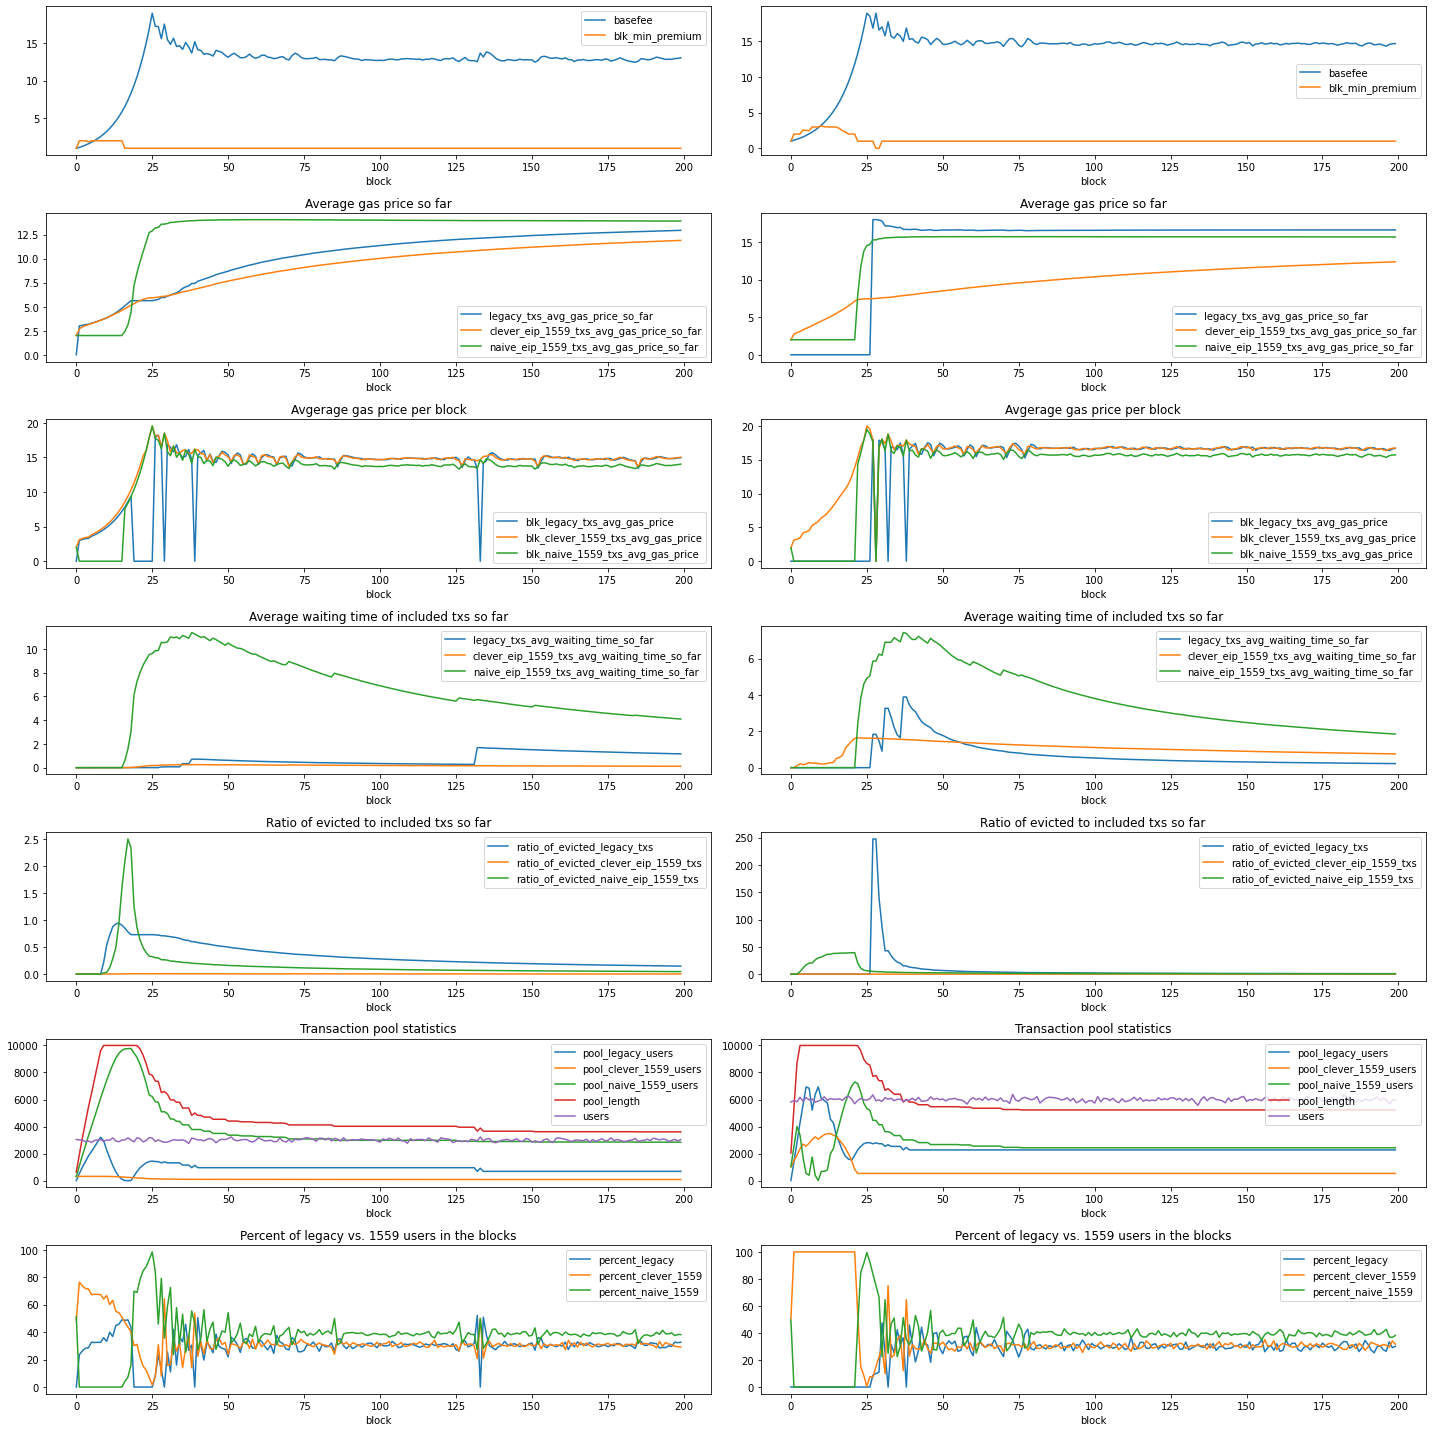

In [16]:
drawAllPlots(res, True)

We can also draw individual figure for each plot.

In [17]:
#(df, user_pool, chain, _) = res[1]
#drawPlots(df, user_pool, chain, -1, None)

## Summary

__Comments and suggestions are welcome.__

Plots on the left show us results for 3000 users (1000 x `LegacyUser` + 1000 x `CleverUser1559` + 1000 x `User1559`) submitting transactions in each iteration and on the right accordignly for 6000 users. The dynamics are different but general trends seem to be the same.

1. The first 2 diagrams show us that initially _basefee_ grows quickly, then drops and reaches stabilization. It is the same behaviour that was observed in different simulations like [__Stationary behaviour of EIP 1559 agent-based model__](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb) or [__Strategic users in EIP 1559__](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb). 

1. Next we have plots showing statistics about gas prices. `Average gas price so far` average gas price over all blocks and `Average gas price per block` average gas price per each block. 
    1. If we look at `Average gas price per block` then, in general, naive EIP-1559 users pay less than legacy users or clever EIP-1559 users because they do not compete. If we compare legacy users vs clever EIP-1559 users it turns out that they pay similarly.
    1. However, if we look at `Average gas price so far` the average for naive EIP-1559 users is the highest because they are not included in blocks when `basefee` is low (due to the competition). For the same reason, the average values for clever EIP-1559 users are the lowest because mainly transactions of clever EIP-1559 users are included in blocks at the beginning of the simulation.
    
1. `Average waiting time of included txs so far` diagrams show us that naive EIP-1559 users will wait for the longest. It is not surprising because naive users always pay the same gas premium = 1 gwei so they lose the competition with more clever users. What is interesting, is the fact that in the one case (3000 users) legacy users wait a little bit longer than clever EIP-1559 users, and in the second case another way round. I'm not sure why it happens.

1. `Ratio of evicted to included txs so far` diagrams show us that eviction is applied mainly to transactions submitted by legacy and naive users and that after stabilization of `basefee` it drops almost to 0 what means that there are no evictions. High eviction rate at the beginning of the simulation can be explained by the fact that at this stage mainly transactions submitted by clever EIP-1559 users are included in the blocks. At the same time _basefee_ is low so all users try to submit transactions which fills a pool and need to be evicted at some point.

1. Next we can see the transaction pool statistics over time. Initially it grows very quickly and then drops because less users is willing to pay higher values of _basefee_. It is the same behaviour that was observed in different simulations like [__Stationary behaviour of EIP 1559 agent-based model__](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb) or [__Strategic users in EIP 1559__](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb). 

1. `Percent of legacy vs. 1559 users in the blocks` diagrams show us that transactions submitted by all types of users are included in blocks when _basefee_ reaches stablization. It's good. What is very interesting is the fact that around 40% of transactions in blocks (after stablization of  _basefee_) are transactions submitted by naive users. I would expect more transactions from legacy or from clever users and I'm not sure how to exlain this behaviour. It is also worth pointing that in the in the beginning of the simulation, when _basefee_ grows, mainly transactions of clever EIP-1559 users are included in blocks.

## TODO

1. Further analysis and clarificaiton of results.
1. Currently prices / tips for legacy and clever EIP-1559 users are estimated once per iteration of the simulation. It can be done more realistics. The idea is to generate users one by one (not in 1 big batch) and estimate prices / tips for them independently.